In [33]:
import numpy as np
import csv
import networkx as nx
import time
import matplotlib.pyplot as plt
import seaborn as sns; sns.set()
import multiprocessing as mp
from scipy.integrate import odeint

In [34]:
# generate a network structure
def network(param_nx, structure = 'complete'):
    '''
    param_nx: dictionary of parameters
    structure: type of network
    '''
    if structure == 'complete': # complete graph
        G = nx.complete_graph(param_nx['N'])
    elif structure == 'lattice': # two-dimensional grid graph (square or rectangle)
        G = nx.grid_2d_graph(param_nx['L'], param_nx['H'], periodic = True) 
    elif structure == 'ER': # Erdős-Rényi graph
        G = nx.erdos_renyi_graph(param_nx['N'], param_nx['p'])
    elif structure == 'WS': # Watts–Strogatz small-world graph
        G = nx.watts_strogatz_graph(param_nx['N'], param_nx['k'], param_nx['b'])
    elif structure == 'BA': # Barabási–Albert preferential attachment
        G = nx.barabasi_albert_graph(param_nx['N'], param_nx['m'])

    print(nx.info(G)) # basic information
    return nx.to_numpy_array(G) # adjacency matrix

In [41]:
# Gillespie算法模拟在任意网络上的SIRV传播过程
def SIRV_network_Gillespie(A, y_0, param, output='solution'):
    # 初始化
    N = A.shape[0]
    degree = np.sum(A) / A.shape[0]
    beta, gamma, epsilon = param['beta'] / degree, param['gamma'], param['epsilon']
    I_0 = int(N * y_0[1])
    V_0 = int(N * y_0[3])
    t = [0]
    S, I, R, V = [N - I_0 - V_0], [I_0], [0], [V_0]
    state = np.array([0]*S[0] + [1]*V_0 + [2]*I_0).reshape((N,))#S=0, V=1, I=2,  R=3
    np.random.shuffle(state)

    # 更新propensities 
    prop = beta * A.dot(state == 2) * (state == 0) + \
           (1-epsilon) * beta * A.dot(state == 2) * (state == 1) + \
           gamma * (state == 2)

    # 更新
    while I[-1] > 0: 
        r_1, r_2 = np.random.rand(2)
        cumsum = prop.cumsum()
        scale = cumsum[-1]
        tau = -np.log(1 - r_1) / scale
        t.append(t[-1] + tau)
        i = np.searchsorted(cumsum, r_2 * scale)
        if state[i] == 0: #S to I
            S.append(S[-1] - 1); I.append(I[-1] + 1); R.append(R[-1]); V.append(V[-1])
            state[i] = 2
        elif state[i] == 1:#VtoI
            S.append(S[-1]); I.append(I[-1] + 1); R.append(R[-1]); V.append(V[-1] - 1)
            state[i] = 2
        elif state[i] == 2:#I to R
            S.append(S[-1]); I.append(I[-1] - 1); R.append(R[-1] + 1); V.append(V[-1])
            state[i] = 3

        # 更新propensities 
        prop = beta * A.dot(state == 2) * (state == 0) + \
               (1-epsilon) * beta * A.dot(state == 2) * (state == 1) + \
               gamma * (state == 2)

    if output == 'solution':
        return t, np.column_stack((S, I, R, V))
    else:
        return state


C:\Users\Yuan\AppData\Local\Temp\ipykernel_14104\4094712956.py:18: DeprecationWarning: info is deprecated and will be removed in version 3.0.

  print(nx.info(G)) # basic information


Graph with 1000 nodes and 5000 edges


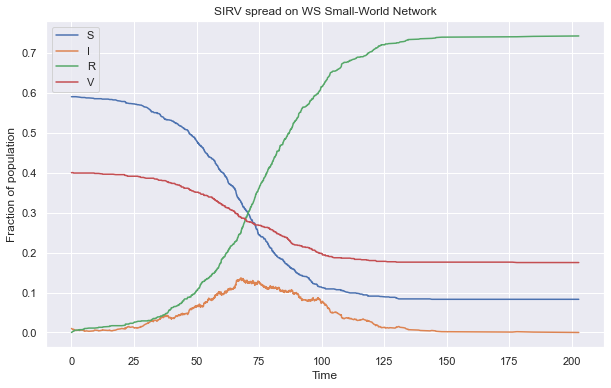

In [40]:
# 测试WS小世界网络
N = 1000
A = network({'N': N, 'k': 10, 'b': 0.2}, structure='WS') # k: 每个节点的近邻数量, b: 重连概率

y_0 = [1 - 1e-2 - 0.4, 1e-2, 0, 0.4]
param = {'beta': 0.35, 'gamma': 0.1, 'epsilon': 0.6}

t, solution = SIRV_network_Gillespie(A, y_0, param)

# 可视化结果
plt.figure(figsize=(10,6))
plt.plot(t, np.array(solution[:, 0])/N, label='S')
plt.plot(t, np.array(solution[:, 1])/N, label='I')
plt.plot(t, np.array(solution[:, 2])/N, label='R')
plt.plot(t, np.array(solution[:, 3])/N, label='V')
plt.xlabel('Time')
plt.ylabel('Fraction of population')
plt.legend()
plt.title('SIRV spread on WS Small-World Network')
plt.show()


In [42]:



'''
def SIRV_equation(y, t, param):
    S, I, R, V = y
    beta, gamma, epsilon = param['beta'], param['gamma'], param['epsilon']
    N = S + I + R + V
    dS = -beta * S * I / N + epsilon * beta * V * I / N
    dI = beta * S * I / N - gamma * I - epsilon * beta * V * I / N
    dR = gamma * I
    dV = 0  # 这里，我们假设一旦接种，那么人就不会失去其疫苗的效果
    return [dS, dI, dR, dV]

'''
def SIRV_equation(y, t, param):
    beta, gamma, epsilon = param['beta'], param['gamma'], param['epsilon']
    S, I, R, V = y
    return [-beta*S*I , beta*S*I + (1-epsilon)*beta*V*I - gamma*I, gamma*I, - (1-epsilon)*beta*V*I]


def SIRV_ode(y_0, t, param):
    solution = odeint(SIRV_equation, y_0, t, args=(param,))
    return solution

C:\Users\Yuan\AppData\Local\Temp\ipykernel_14104\4094712956.py:18: DeprecationWarning: info is deprecated and will be removed in version 3.0.

  print(nx.info(G)) # basic information


Graph with 1000 nodes and 499500 edges
ODE: 0.030895, 0.003448, 0.842722, 0.122935
SIRV_network_Gillespie: 0.0341, 0.0, 0.8378, 0.1281
time: 15.680557


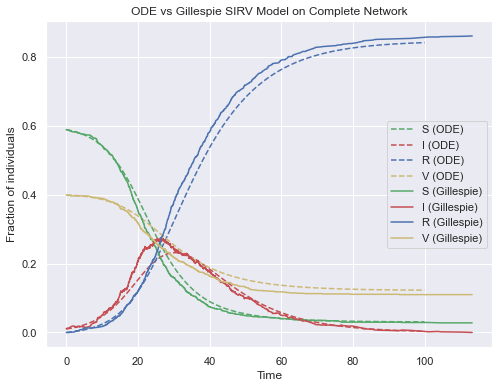

In [46]:
#SIRV -test
N = 1000
A = network({'N': N}, structure='complete')
y_0 = [1 - 1e-2-0.4, 1e-2, 0, 0.4]
param = {'beta': 0.35, 'gamma': 0.1, 'epsilon':0.6}


# ODE部分
t_ode = np.linspace(0, 100, 1001)
solution_ode = SIRV_ode(y_0, t_ode, param)
solution_ode = np.around(solution_ode, decimals=6)
print('ODE: ' + ", ".join([str(v) for v in solution_ode[-1]]))

# Gillespie模拟部分

t_gillespie, solution_gillespie = SIRV_network_Gillespie(A, y_0, param, output = 'solution')

repetition = 10
start = time.time()
mean_SIRV = np.zeros(4)
for i in range(repetition):
    t, solution = SIRV_network_Gillespie(A, y_0, param)
    mean_SIRV += solution[-1]
mean_SIRV = mean_SIRV / repetition / N
mean_SIRV = np.around(mean_SIRV, decimals=6)
end = time.time()
print('SIRV_network_Gillespie' + ': ' + ", ".join([str(v) for v in mean_SIRV]))
print('time: ' + str(np.around(end - start, decimals=6)))

# 绘图
plt.figure(figsize=(8, 6))

# ODE结果
plt.plot(t_ode, solution_ode[:, 0], 'g--', label='S (ODE)')
plt.plot(t_ode, solution_ode[:, 1], 'r--', label='I (ODE)')
plt.plot(t_ode, solution_ode[:, 2], 'b--', label='R (ODE)')
plt.plot(t_ode, solution_ode[:, 3], 'y--', label='V (ODE)')

# Gillespie模拟结果
plt.plot(t, np.array(solution[:, 0])/N, 'g', label='S (Gillespie)')
plt.plot(t, np.array(solution[:, 1])/N, 'r', label='I (Gillespie)')
plt.plot(t, np.array(solution[:, 2])/N, 'b', label='R (Gillespie)')
plt.plot(t, np.array(solution[:, 3])/N, 'y', label='V (Gillespie)')

plt.xlabel('Time')
plt.ylabel('Fraction of individuals')
plt.title('ODE vs Gillespie SIRV Model on Complete Network')
plt.legend()
plt.show()
